In [1]:
import numpy as np
import matplotlib.pyplot as plt
from SimPEG.electromagnetics import resistivity as DC
from discretize import TensorMesh
from SimPEG import maps
from SimPEG.electromagnetics.static.resistivity import DCSimulation_1D
from SimPEG.electromagnetics.static.utils import StaticUtils

ModuleNotFoundError: No module named 'SimPEG.utils'

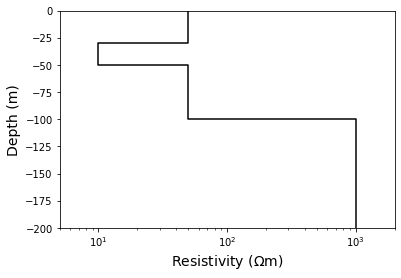

In [2]:
ntx = 11
xtemp_txP = np.logspace(1, np.log10(1000.), ntx)
xtemp_txN = -xtemp_txP
ytemp_tx = np.zeros(ntx)
xtemp_rxP = -5
xtemp_rxN = 5
ytemp_rx = 0. 
abhalf = abs(xtemp_txP-xtemp_txN)*0.5
a = xtemp_rxN-xtemp_rxP
b = ((xtemp_txN-xtemp_txP)-a)*0.5

# We generate tx and rx lists:
srclist = []
for i in range(ntx):
    rx = DC.Rx.Dipole(np.r_[xtemp_rxP, ytemp_rx, -12.5], np.r_[xtemp_rxN, ytemp_rx, -12.5])
    locA = np.r_[xtemp_txP[i], ytemp_tx[i], -12.5]
    locB = np.r_[xtemp_txN[i], ytemp_tx[i], -12.5]
    src = DC.Src.Dipole([rx], locA, locB)
    srclist.append(src)
survey = DC.Survey(srclist)    
dz_min=5.
hz = np.r_[30, 20, 50, 100]
mesh_1d = TensorMesh([hz])
rho = np.r_[50, 10, 50, 1000]
StaticUtils.plot_layer(rho, mesh_1d)

In [4]:
wires.rho

In [5]:
wires = maps.Wires(('rho', mesh_1d.nC), ('t', mesh_1d.nC-1))
mapping_rho = maps.ExpMap(nP=mesh_1d.nC) * wires.rho
mapping_t = maps.ExpMap(nP=mesh_1d.nC-1) * wires.t
# mapping_t = wires.t
simulation = DCSimulation_1D(
    mesh=mesh_1d, 
    rhoMap=mapping_rho,
    tMap=mapping_t,    
    survey=survey, 
    data_type='apparent_resistivity'
)

In [7]:
from SimPEG import Data

In [8]:
from SimPEG import (
    maps, data_misfit, regularization,
    optimization, inverse_problem, inversion, directives
)
survey.std = 0.01
survey.eps = 1.

In [9]:
m = np.r_[np.log(rho), np.log(hz[:-1])]
# m = np.r_[np.log(rho), hz[:-1]]

In [10]:
%%time
dobs = simulation.makeSyntheticData(m)

CPU times: user 7.2 ms, sys: 2.01 ms, total: 9.22 ms
Wall time: 7.87 ms


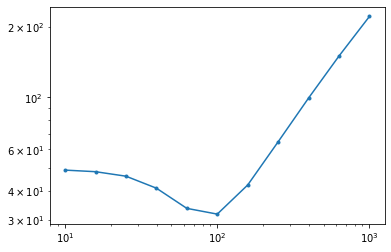

In [11]:
ab = simulation.electrode_separations['AB']
plt.loglog(ab/2, dobs.dobs, '.-')

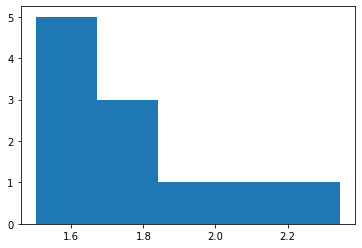

In [12]:
out = plt.hist(np.log10(dobs.dobs), bins=5)
rho0 = 10**out[1][np.argmax(out[0])]

In [13]:
dmis = data_misfit.L2DataMisfit(simulation=simulation, data=dobs)
floor = 0.
std = 0.01
uncert = abs(dobs.dobs) * std + floor
dmis.W = 1./uncert

In [14]:
mesh_rho = TensorMesh([mesh_1d.hx.size])
reg_rho = regularization.Simple(
    mesh_rho, alpha_s=1., alpha_x=1.,
    mapping=wires.rho
)
mesh_t = TensorMesh([mesh_1d.hx.size-1])
reg_t = regularization.Simple(
    mesh_t, alpha_s=1., alpha_x=1.,
    mapping=wires.t    
)
reg = reg_rho + reg_t
opt = optimization.InexactGaussNewton(
    maxIter=30, maxIterCG=20
)
invProb = inverse_problem.BaseInvProblem(dmis, reg, opt)
target = directives.TargetMisfit()
# Create an inversion object
beta = directives.BetaSchedule(coolingFactor=2., coolingRate=1.)
betaest = directives.BetaEstimate_ByEig(beta0_ratio=1e0)
save =  directives.SaveOutputDictEveryIteration()
inv = inversion.BaseInversion(invProb, directiveList=[beta, target, save, betaest])
# inv = inversion.BaseInversion(invProb, directiveList=[beta, target, save])
opt.remember('xc')
MOPT = []
# rho_s = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
rho_s = np.logspace(np.log10(dobs.dobs.min()), np.log10(dobs.dobs.max()), 10)
for rho0 in rho_s:
    m0 = np.r_[np.log(np.ones(rho.size)*rho0), np.log(np.ones(rho.size-1) * 10.)]
#     m0 = np.r_[np.log(np.ones(rho.size)*rho0), np.ones(rho.size-1) * 10.]    
    mopt = inv.run(m0)
    if target.target > invProb.phi_d:
        MOPT.append(mopt)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
SimPEG.SaveOutputDictEveryIteration will save your inversion progress as dictionary: '###-InversionModel-2019-11-30-01-55.npz'
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.64e+03  1.27e+04  0.00e+00  1.27e+04    1.13e+04      0              
   1  2.32e+03  8.43e+03  1.94e-01  8.88e+03    2.41e+03      0              
   2  1.16e+03  7.58e+03  3.94e-01  8.04e+03    2.78e+03      0   Skip BFGS  
   3  5.80e+02  5.83e+03  1.15e+00  6.50e+03    3.99e+03      0              
   4  2.90e+02  3.09e+03  3.73e+00  4.18e

   2  6.53e+03  9.12e+03  1.03e-01  9.79e+03    2.77e+03      0   Skip BFGS  
   3  3.27e+03  8.61e+03  1.59e-01  9.13e+03    2.84e+03      0              
   4  1.63e+03  7.95e+03  2.89e-01  8.42e+03    2.56e+03      0              
   5  8.17e+02  6.74e+03  6.93e-01  7.31e+03    3.26e+03      0              
   6  4.08e+02  4.30e+03  2.26e+00  5.22e+03    4.51e+03      0              
   7  2.04e+02  1.69e+03  5.48e+00  2.80e+03    4.58e+03      0              
   8  1.02e+02  4.35e+02  7.56e+00  1.21e+03    1.33e+03      0   Skip BFGS  
   9  5.11e+01  1.77e+02  9.27e+00  6.50e+02    1.33e+03      0   Skip BFGS  
  10  2.55e+01  1.00e+02  1.01e+01  3.57e+02    2.49e+02      0   Skip BFGS  
  11  1.28e+01  2.93e+01  1.16e+01  1.78e+02    5.52e+02      0              
  12  6.38e+00  1.05e+01  1.24e+01  8.98e+01    8.19e+01      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 7.1494e+03
1 : |xc-x_last| = 2.9437e-0

   2  3.68e+04  9.98e+03  5.52e-02  1.20e+04    6.75e+03      0   Skip BFGS  
   3  1.84e+04  1.06e+04  2.61e-02  1.11e+04    4.37e+03      0   Skip BFGS  
   4  9.20e+03  9.79e+03  5.79e-02  1.03e+04    4.20e+03      0              
   5  4.60e+03  8.97e+03  1.17e-01  9.51e+03    3.30e+03      0   Skip BFGS  
   6  2.30e+03  8.31e+03  2.09e-01  8.79e+03    2.67e+03      0   Skip BFGS  
   7  1.15e+03  7.46e+03  4.28e-01  7.95e+03    2.79e+03      0   Skip BFGS  
   8  5.75e+02  5.65e+03  1.24e+00  6.36e+03    3.95e+03      0              
   9  2.87e+02  2.95e+03  3.85e+00  4.05e+03    4.86e+03      0              
  10  1.44e+02  7.51e+02  6.59e+00  1.70e+03    2.36e+03      0   Skip BFGS  
  11  7.18e+01  2.80e+02  8.55e+00  8.94e+02    1.62e+03      0   Skip BFGS  
  12  3.59e+01  1.51e+02  9.41e+00  4.88e+02    4.09e+02      0   Skip BFGS  
  13  1.80e+01  4.44e+01  1.12e+01  2.45e+02    7.32e+02      0   Skip BFGS  
  14  8.98e+00  1.82e+01  1.19e+01  1.25e+02    1.64e+02      0 

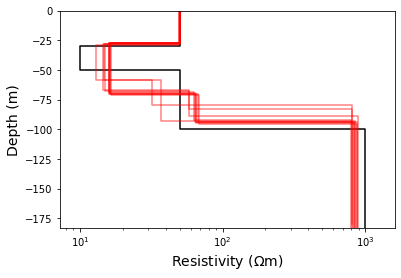

In [15]:
StaticUtils.plot_layer(rho, mesh_1d)
for mopt in MOPT:
    rho_est = mapping_rho * mopt
    t_est = mapping_t * mopt
    mesh_tmp = TensorMesh([np.r_[t_est, 100]])
    StaticUtils.plot_layer(rho_est, mesh_tmp, showlayers=False, **{'color':'r', 'alpha':0.5})

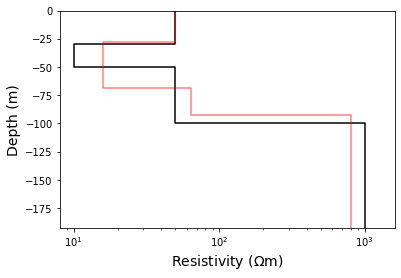

In [31]:
StaticUtils.plot_layer(rho, mesh_1d)
ii = 0
mopt = MOPT[ii]
rho_est = mapping_rho * mopt
t_est = mapping_t * mopt
mesh_tmp = TensorMesh([np.r_[t_est, 100]])
StaticUtils.plot_layer(rho_est, mesh_tmp, showlayers=False, **{'color':'r', 'alpha':0.5})

In [17]:
# StaticUtils.plot_layer(rho, mesh_1d)
# rho_est = mapping_rho * save.outDict[len(save.outDict)]['m']
# t_est = mapping_t * save.outDict[len(save.outDict)]['m']
# mesh_tmp = TensorMesh([np.r_[t_est, 100]])
# StaticUtils.plot_layer(rho_est, mesh_tmp, showlayers=False, **{'color':'r'})

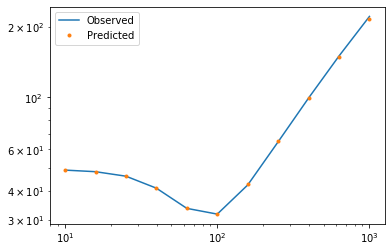

In [18]:
ab = simulation.electrode_separations['AB']
plt.loglog(ab/2., dobs.dobs, '-')
plt.loglog(ab/2., save.outDict[len(save.outDict)]['dpred'], '.')
plt.legend(("Observed", "Predicted"))